# Evaluation pipeline

## 0 Imports and Constants

In [1]:
import sys
import os

# Füge das übergeordnete Verzeichnis zu sys.path hinzu
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '../../'))
sys.path.insert(0, parent_dir)

In [2]:
import pandas as pd
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import seaborn as sns
from copy import deepcopy as dc

from utilities import split_data_into_sequences, load_sequential_time_series, reconstruct_sequential_data, Scaler, extract_features_and_targets_reg, get_discriminative_test_performance
from data_evaluation.visual.visual_evaluation import visual_evaluation
from predictive_evaluation import predictive_evaluation

In [3]:
DATA_FOLDER = Path("../../data")
REAL_DATA_FOLDER = DATA_FOLDER / "real"
SYNTHETIC_DATA_FOLDER = DATA_FOLDER / "synthetic" / "usable" / "1y"

## 1 Load and Visualize Data

### Ways of loading data
- Laden der Originaldaten: als pd dataframe 
- Laden der synthetischen, sequentiellen Daten: als np array (GAN, (V)AE)
- Laden der synthetischen, sequentiellen Daten: als pd dataframe (brownian, algorithmit)

In [4]:
# possible types: 'timegan_lstm', 'timegan_gru', 'jitter', 'timewarp', 'autoencoder', 'vae'
syn_data_type = 'jitter'

In [5]:
# Load real time series
data_train_real_df = pd.read_csv(REAL_DATA_FOLDER/'mitv_prep_1y.csv')
data_train_real_numpy = dc(data_train_real_df).to_numpy()

data_test_real_df = pd.read_csv(REAL_DATA_FOLDER/'mitv_prep_3mo.csv')
data_test_real_numpy = dc(data_test_real_df).to_numpy()

if syn_data_type == 'timegan_lstm':
    # load sequential data (which should already be scaled)
    data_syn_numpy = load_sequential_time_series(SYNTHETIC_DATA_FOLDER/'mitv_28499_12_5_lstm_unscaled.csv', shape=(28499, 12, 5))

elif syn_data_type == 'timegan_gru':
    data_syn_numpy = load_sequential_time_series(SYNTHETIC_DATA_FOLDER/'mitv_28499_12_5_gru_unscaled.csv', shape=(28499, 12, 5))

elif syn_data_type == 'autoencoder':
    data_syn_numpy = load_sequential_time_series(SYNTHETIC_DATA_FOLDER/'mitv_28478_12_5_lstm_autoencoder_unscaled_15.csv', shape=(28478, 12, 5))

elif syn_data_type == 'vae':
    data_syn_numpy = load_sequential_time_series(SYNTHETIC_DATA_FOLDER/'mitv_28511_12_5_lstm_vae_unscaled.csv', shape=(28511, 12, 5))

elif syn_data_type == 'jitter':
    data_syn_df = pd.read_csv(SYNTHETIC_DATA_FOLDER/f'jittered_01.csv')
    data_syn_numpy = dc(data_syn_df).to_numpy()

elif syn_data_type == 'timewarp':
    data_syn_df = pd.read_csv(SYNTHETIC_DATA_FOLDER/f'time_warped.csv')
    data_syn_numpy = dc(data_syn_df).to_numpy()

# Loot at real and syn data
df = pd.DataFrame(data_syn_numpy.reshape(-1, data_syn_numpy.shape[-1]), columns=data_train_real_df.columns)

print('\n\n syn data:\n')
print(df.describe())

print('\n\nreal train data:\n')
print(data_train_real_df.describe())

print('\n\nreal test data:\n')
print(data_test_real_df.describe())



 syn data:

       traffic_volume         temp      rain_1h      snow_1h   clouds_all
count     8759.000000  8759.000000  8759.000000  8759.000000  8759.000000
mean      3242.999554   282.195389     0.121158     0.000483    44.847967
std       1954.971277    12.166623     0.900317     0.006140    38.883359
min          0.000000   242.975253     0.000000     0.000000     0.000000
25%       1266.647637   273.603328     0.000000     0.000000     2.874516
50%       3413.554372   283.584600     0.003998     0.000016    40.097688
75%       4869.564219   292.030356     0.069818     0.000425    87.130849
max       7355.044574   309.647461    42.019570     0.250347   104.283866


real train data:

       traffic_volume         temp      rain_1h      snow_1h   clouds_all
count     8759.000000  8759.000000  8759.000000  8759.000000  8759.000000
mean      3244.668912   282.208136     0.086792     0.000233    44.397306
std       1946.247953    12.114907     0.901360     0.006145    39.195308
min 

## 2 Predictive Evaluation

### Set Hyperparameters and Features

In [6]:
hyperparameters = {
    "seq_len": 12,
    "lr": 0.0001,
    "batch_size": 32,
    "hidden_size": 12,
    "num_layers": 1,
    "bidirectional": True,
    "num_evaluation_runs": 10,
    "num_epochs": 400,
    "device": 'cuda' if torch.cuda.is_available() else 'cpu'
}

In [7]:
# evaluate predictive performance
predictive_results = predictive_evaluation(
    data_train_real=data_train_real_numpy, 
    data_test_real=data_test_real_numpy,
    data_syn=data_syn_numpy, 
    hyperparameters=hyperparameters, 
    include_baseline=True, 
    verbose=True)

# save results
bidirectionality = "bi" if hyperparameters["bidirectional"] else 'no_bi'
predictive_results.to_csv(DATA_FOLDER / f"results_{syn_data_type}_{hyperparameters['num_epochs']}_{hyperparameters['num_evaluation_runs']}_{bidirectionality}.csv", index=False)

# split in mse and mae results
mse_results = predictive_results.loc[predictive_results['Metric'] == 'MSE']
mae_results = predictive_results.loc[predictive_results['Metric'] == 'MAE']

HYPERPARAMETERS:
seq_len :  12
lr :  0.0001
batch_size :  32
hidden_size :  12
num_layers :  1
bidirectional :  True
num_evaluation_runs :  10
num_epochs :  400
device :  cpu
Synthetic Data is sequential: False
Shape of the data after splitting into sequences: (8748, 12, 5)
Shape of the data after splitting into sequences: (1057, 12, 5)
Shape of the data after splitting into sequences: (1056, 12, 5)


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1
Train Loss: 0.38202117769605054 // Train Acc: 0.02281021897810219
Val Loss: 0.2727571666131125 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.03217184833203354 // Train Acc: 0.011405109489051095
Val Loss: 0.03578124299426289 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.012573079783877316 // Train Acc: 0.011405109489051095
Val Loss: 0.014087841387235504 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.01079159299673064 // Train Acc: 0.011405109489051095
Val Loss: 0.011790921480175765 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.009882438267210676 // Train Acc: 0.011405109489051095
Val Loss: 0.010540508767863846 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.009212761836969396 // Train Acc: 0.011405109489051095
Val Loss: 0.009553630521301837 // Val Acc: 0.0
***

c:\Users\fanny\Documents\ArnesShit\time_series_data_augmentation\data_evaluation\predictive\predictive_evaluation.py:277: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame([{'Model': evaluation_method, 'Metric': 'MAE', 'Error': mae}])], ignore_index=True)
 10%|█         | 1/10 [02:45<24:46, 165.17s/it]

Epoch: 1
Train Loss: 0.15671525440131226 // Train Acc: 0.011405109489051095
Val Loss: 0.1183478479301009 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.02187787253158099 // Train Acc: 0.011405109489051095
Val Loss: 0.023762117934358472 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.011961495226340872 // Train Acc: 0.011405109489051095
Val Loss: 0.013048997813123553 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.010232319467765599 // Train Acc: 0.011405109489051095
Val Loss: 0.01095890492433682 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.00927824251282362 // Train Acc: 0.011405109489051095
Val Loss: 0.009658767139840433 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.008543861196308403 // Train Acc: 0.011405109489051095
Val Loss: 0.008758942288456155 // Val Acc: 0.0
**

 20%|██        | 2/10 [05:26<21:41, 162.74s/it]

Epoch: 1
Train Loss: 0.106816287465176 // Train Acc: 0.011405109489051095
Val Loss: 0.09828081058666986 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.027717284790247026 // Train Acc: 0.011405109489051095
Val Loss: 0.02999363450662178 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.012142107172369495 // Train Acc: 0.011405109489051095
Val Loss: 0.01352470345548628 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.010812445437488058 // Train Acc: 0.011405109489051095
Val Loss: 0.01164776981150841 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.009998685782299425 // Train Acc: 0.011405109489051095
Val Loss: 0.010536485255750664 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.009069603262384198 // Train Acc: 0.011405109489051095
Val Loss: 0.009516776255194974 // Val Acc: 0.0
***

 30%|███       | 3/10 [08:08<18:58, 162.59s/it]

Epoch: 1
Train Loss: 0.07392983271801559 // Train Acc: 0.011405109489051095
Val Loss: 0.07297869377276477 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.01647482799998328 // Train Acc: 0.011405109489051095
Val Loss: 0.01815970244762652 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.011864672168319447 // Train Acc: 0.011405109489051095
Val Loss: 0.01288605177336756 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.010046007830554442 // Train Acc: 0.011405109489051095
Val Loss: 0.0109021467026597 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.0089324113350348 // Train Acc: 0.011405109489051095
Val Loss: 0.010002604398109457 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.008320692431667725 // Train Acc: 0.011405109489051095
Val Loss: 0.009398336077163763 // Val Acc: 0.0
*****

 40%|████      | 4/10 [08:53<11:37, 116.29s/it]

INFO: Validation loss did not improve in epoch 112
Early stopping after 112 epochs
Epoch: 1
Train Loss: 0.07979519852185554 // Train Acc: 0.011405109489051095
Val Loss: 0.07768256315851912 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.018033946351909563 // Train Acc: 0.011405109489051095
Val Loss: 0.020166905206518575 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.01217967633542054 // Train Acc: 0.011405109489051095
Val Loss: 0.013363144470050055 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.0097042308930379 // Train Acc: 0.011405109489051095
Val Loss: 0.01031801917398458 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.008382515829688714 // Train Acc: 0.011405109489051095
Val Loss: 0.0084419387515963 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.007824102005781946 // 

 50%|█████     | 5/10 [10:13<08:35, 103.10s/it]

INFO: Validation loss did not improve in epoch 196
Early stopping after 196 epochs
Epoch: 1
Train Loss: 0.1083860789174146 // Train Acc: 0.011405109489051095
Val Loss: 0.08873384539037943 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.02170243307295507 // Train Acc: 0.011405109489051095
Val Loss: 0.023914656629238057 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.01154218054415631 // Train Acc: 0.011405109489051095
Val Loss: 0.012805076761116438 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.009215994415138542 // Train Acc: 0.011405109489051095
Val Loss: 0.010123557630268967 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.008360740683639735 // Train Acc: 0.011405109489051095
Val Loss: 0.009095575585139586 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.007916826198224224 

 60%|██████    | 6/10 [11:24<06:08, 92.16s/it] 

INFO: Validation loss did not improve in epoch 172
Early stopping after 172 epochs
Epoch: 1
Train Loss: 0.3174014524250788 // Train Acc: 0.02281021897810219
Val Loss: 0.26176519686465755 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.03151935701306066 // Train Acc: 0.011405109489051095
Val Loss: 0.03451545120162122 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.013483832187501944 // Train Acc: 0.011405109489051095
Val Loss: 0.014771208625889438 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.009278283403492975 // Train Acc: 0.011405109489051095
Val Loss: 0.010239275898236562 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.008091757427493152 // Train Acc: 0.011405109489051095
Val Loss: 0.008843204116120058 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.007291585408800356 /

 70%|███████   | 7/10 [12:06<03:47, 75.72s/it]

INFO: Validation loss did not improve in epoch 100
Early stopping after 100 epochs
Epoch: 1
Train Loss: 0.2790559481176799 // Train Acc: 0.02281021897810219
Val Loss: 0.18441490379079958 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.025965495354557125 // Train Acc: 0.011405109489051095
Val Loss: 0.028645414256435985 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.012018530256961249 // Train Acc: 0.011405109489051095
Val Loss: 0.013353593085947283 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.0098552961504923 // Train Acc: 0.011405109489051095
Val Loss: 0.010637050501399618 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.008901351120239667 // Train Acc: 0.011405109489051095
Val Loss: 0.009512769373352914 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.008397156661155423 /

 80%|████████  | 8/10 [14:52<03:28, 104.49s/it]

Epoch: 1
Train Loss: 0.21142676188848422 // Train Acc: 0.011405109489051095
Val Loss: 0.15842335900250712 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.026385417765509473 // Train Acc: 0.011405109489051095
Val Loss: 0.02895818349412259 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.012094631603745621 // Train Acc: 0.011405109489051095
Val Loss: 0.013098942040575339 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.009680853844756247 // Train Acc: 0.011405109489051095
Val Loss: 0.010277772685238981 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.008142471579872208 // Train Acc: 0.011405109489051095
Val Loss: 0.008549375808797777 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.007303825650962382 // Train Acc: 0.011405109489051095
Val Loss: 0.0077473255257834404 // Val Acc: 0.

 90%|█████████ | 9/10 [15:32<01:24, 84.33s/it] 

INFO: Validation loss did not improve in epoch 97
Early stopping after 97 epochs
Epoch: 1
Train Loss: 0.12088662779543304 // Train Acc: 0.011405109489051095
Val Loss: 0.09347203045206912 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.0220061384182233 // Train Acc: 0.011405109489051095
Val Loss: 0.024476332042147133 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.011741731008667716 // Train Acc: 0.011405109489051095
Val Loss: 0.012877502095173387 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.009490778157317562 // Train Acc: 0.011405109489051095
Val Loss: 0.01023762927198892 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.00839450572070115 // Train Acc: 0.011405109489051095
Val Loss: 0.00922973662176553 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.007806762077430957 // T

100%|██████████| 10/10 [18:16<00:00, 109.66s/it]


Shape of the data after splitting into sequences: (6996, 12, 5)
Shape of the data after splitting into sequences: (1741, 12, 5)
Shape of the data after splitting into sequences: (8748, 12, 5)


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1
Train Loss: 0.3912803360503422 // Train Acc: 0.028538812785388126
Val Loss: 0.27503037655895407 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.034248628934258465 // Train Acc: 0.014269406392694063
Val Loss: 0.02831870698454705 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.016370757183136596 // Train Acc: 0.014269406392694063
Val Loss: 0.014490563291209665 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.012294442249359945 // Train Acc: 0.014269406392694063
Val Loss: 0.010759333631193095 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.010035303860932555 // Train Acc: 0.014269406392694063
Val Loss: 0.008692310881716283 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.008801317672228194 // Train Acc: 0.014269406392694063
Val Loss: 0.007433846901932901 // Val Acc: 0.0


 10%|█         | 1/10 [02:14<20:10, 134.45s/it]

Epoch: 1
Train Loss: 0.10010847308966395 // Train Acc: 0.014269406392694063
Val Loss: 0.07152614132924513 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.03750930484129141 // Train Acc: 0.014269406392694063
Val Loss: 0.03235140893269669 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.014256213161218317 // Train Acc: 0.014269406392694063
Val Loss: 0.011669960715384646 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.010757810275121401 // Train Acc: 0.014269406392694063
Val Loss: 0.008585652336478233 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.00942981859071597 // Train Acc: 0.014269406392694063
Val Loss: 0.007504816962914033 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.008779454749868545 // Train Acc: 0.014269406392694063
Val Loss: 0.006945347036658363 // Val Acc: 0.0
*

 20%|██        | 2/10 [04:27<17:47, 133.42s/it]

Epoch: 1
Train Loss: 0.16125215803906662 // Train Acc: 0.014269406392694063
Val Loss: 0.09466067630458962 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.03146814184101749 // Train Acc: 0.014269406392694063
Val Loss: 0.027316736768592486 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.015360919316405574 // Train Acc: 0.014269406392694063
Val Loss: 0.013443373219872063 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.012234470240355014 // Train Acc: 0.014269406392694063
Val Loss: 0.01023026909255846 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.010597917230557394 // Train Acc: 0.014269406392694063
Val Loss: 0.008617208834568207 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.009339249941103637 // Train Acc: 0.014269406392694063
Val Loss: 0.007494697105986151 // Val Acc: 0.0


 30%|███       | 3/10 [06:40<15:32, 133.23s/it]

Epoch: 1
Train Loss: 0.09111543736297247 // Train Acc: 0.014269406392694063
Val Loss: 0.05975138179280541 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.022900465807822196 // Train Acc: 0.014269406392694063
Val Loss: 0.020704684050923045 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.014086006896583082 // Train Acc: 0.014269406392694063
Val Loss: 0.012588847538625653 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.011897545254185422 // Train Acc: 0.014269406392694063
Val Loss: 0.010355210515924475 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.010653979965213466 // Train Acc: 0.014269406392694063
Val Loss: 0.009111061374741521 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.009818234932226166 // Train Acc: 0.014269406392694063
Val Loss: 0.00843639907173135 // Val Acc: 0.0

 40%|████      | 4/10 [08:52<13:18, 133.05s/it]

Epoch: 1
Train Loss: 0.08876168641971943 // Train Acc: 0.014269406392694063
Val Loss: 0.059792680123990236 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.021270418082487228 // Train Acc: 0.014269406392694063
Val Loss: 0.01754450143568895 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.013261798579994266 // Train Acc: 0.014269406392694063
Val Loss: 0.011390052066946571 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.010791137361884135 // Train Acc: 0.014269406392694063
Val Loss: 0.00910664749416438 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.009323751146173674 // Train Acc: 0.014269406392694063
Val Loss: 0.007868724997917359 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.008617266948806913 // Train Acc: 0.014269406392694063
Val Loss: 0.007087194098329002 // Val Acc: 0.0

 50%|█████     | 5/10 [11:06<11:05, 133.13s/it]

Epoch: 1
Train Loss: 0.15985225383447457 // Train Acc: 0.014269406392694063
Val Loss: 0.10236274496736851 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.02305302353252627 // Train Acc: 0.014269406392694063
Val Loss: 0.018856895554133436 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.013238369322437198 // Train Acc: 0.014269406392694063
Val Loss: 0.011262496319514785 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.009956467598485313 // Train Acc: 0.014269406392694063
Val Loss: 0.008773804930123415 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.008195617950104653 // Train Acc: 0.014269406392694063
Val Loss: 0.007245891105214303 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.007564119491237109 // Train Acc: 0.014269406392694063
Val Loss: 0.006473905288360336 // Val Acc: 0.0

 60%|██████    | 6/10 [13:19<08:52, 133.08s/it]

Epoch: 1
Train Loss: 0.15244537436288513 // Train Acc: 0.014269406392694063
Val Loss: 0.09023504318161445 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.023174301612713975 // Train Acc: 0.014269406392694063
Val Loss: 0.02378286597403613 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.014796645744155124 // Train Acc: 0.014269406392694063
Val Loss: 0.013342188942161473 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.011564984709794153 // Train Acc: 0.014269406392694063
Val Loss: 0.009774853259494358 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.010057204325904552 // Train Acc: 0.014269406392694063
Val Loss: 0.008513294723392888 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.009175684660264891 // Train Acc: 0.014269406392694063
Val Loss: 0.0077122388280589475 // Val Acc: 0.

 70%|███████   | 7/10 [15:32<06:39, 133.15s/it]

Epoch: 1
Train Loss: 0.17157139321236306 // Train Acc: 0.014269406392694063
Val Loss: 0.10659464929591525 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.039730398043922095 // Train Acc: 0.014269406392694063
Val Loss: 0.03380082896487279 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.015347228584317788 // Train Acc: 0.014269406392694063
Val Loss: 0.012546146030283787 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.012038925032186659 // Train Acc: 0.014269406392694063
Val Loss: 0.009810751981355927 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.010199733598361889 // Train Acc: 0.014269406392694063
Val Loss: 0.008275940967723727 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.008935242701538724 // Train Acc: 0.014269406392694063
Val Loss: 0.007220151347362183 // Val Acc: 0.0

 80%|████████  | 8/10 [17:45<04:26, 133.13s/it]

Epoch: 1
Train Loss: 0.29977779267313276 // Train Acc: 0.014269406392694063
Val Loss: 0.19275077798149803 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.026156966176870616 // Train Acc: 0.014269406392694063
Val Loss: 0.021872661178084937 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.014475271660200911 // Train Acc: 0.014269406392694063
Val Loss: 0.012761468423361127 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.011879735706016829 // Train Acc: 0.014269406392694063
Val Loss: 0.010186753549020398 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.010761275024740153 // Train Acc: 0.014269406392694063
Val Loss: 0.009128296095877887 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.009921931365045579 // Train Acc: 0.014269406392694063
Val Loss: 0.008433728876777671 // Val Acc: 0.

 90%|█████████ | 9/10 [19:58<02:13, 133.14s/it]

Epoch: 1
Train Loss: 0.20012335581322238 // Train Acc: 0.014269406392694063
Val Loss: 0.14182063127783212 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.03856939426516969 // Train Acc: 0.014269406392694063
Val Loss: 0.032937628911300136 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.01598772829925837 // Train Acc: 0.014269406392694063
Val Loss: 0.013288384942676533 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.012154752297165323 // Train Acc: 0.014269406392694063
Val Loss: 0.010225293052975428 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.010628043173187196 // Train Acc: 0.014269406392694063
Val Loss: 0.008912291610613465 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.009533050380217668 // Train Acc: 0.014269406392694063
Val Loss: 0.008105582625351168 // Val Acc: 0.0


100%|██████████| 10/10 [22:11<00:00, 133.14s/it]


Shape of the data after splitting into sequences: (6996, 12, 5)
Shape of the data after splitting into sequences: (1741, 12, 5)
Shape of the data after splitting into sequences: (8748, 12, 5)


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1
Train Loss: 0.20933349007851185 // Train Acc: 0.1569634703196347
Val Loss: 0.12075715112415226 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.0382294085293532 // Train Acc: 0.014269406392694063
Val Loss: 0.03348616605455225 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.015201519582565177 // Train Acc: 0.014269406392694063
Val Loss: 0.012906788772141391 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.012963278667754643 // Train Acc: 0.014269406392694063
Val Loss: 0.01115609190680764 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.011749765112757955 // Train Acc: 0.014269406392694063
Val Loss: 0.010191315006126057 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.010759975742569967 // Train Acc: 0.05707762557077625
Val Loss: 0.009429993852972985 // Val Acc: 0.0
*****

 10%|█         | 1/10 [02:12<19:53, 132.59s/it]

Epoch: 1
Train Loss: 0.0946380041165439 // Train Acc: 0.014269406392694063
Val Loss: 0.06669894040308215 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.028071539042747184 // Train Acc: 0.014269406392694063
Val Loss: 0.023490126922049305 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.014096698083714944 // Train Acc: 0.014269406392694063
Val Loss: 0.01214058930054307 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.011770644283653599 // Train Acc: 0.028538812785388126
Val Loss: 0.01026736545291814 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.010619507885121286 // Train Acc: 0.09988584474885845
Val Loss: 0.009241471058604392 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.009855386864853231 // Train Acc: 0.09988584474885845
Val Loss: 0.008530354415151205 // Val Acc: 0.05681

 20%|██        | 2/10 [04:24<17:39, 132.41s/it]

Epoch: 1
Train Loss: 0.20142488927499616 // Train Acc: 0.014269406392694063
Val Loss: 0.12813204127279196 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.03397872982351067 // Train Acc: 0.014269406392694063
Val Loss: 0.02910739075053822 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.015781391382251427 // Train Acc: 0.014269406392694063
Val Loss: 0.013284392798827453 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.012588877595544338 // Train Acc: 0.014269406392694063
Val Loss: 0.010492229351604527 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.011142082999303053 // Train Acc: 0.04280821917808219
Val Loss: 0.009219755342399532 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.009958639324719265 // Train Acc: 0.09988584474885845
Val Loss: 0.0083816873756322 // Val Acc: 0.0
****

 30%|███       | 3/10 [06:37<15:26, 132.36s/it]

Epoch: 1
Train Loss: 0.3809484923471054 // Train Acc: 0.8133561643835616
Val Loss: 0.25455792370167646 // Val Acc: 0.5113636363636364
**************************************************
Epoch: 11
Train Loss: 0.043122297084835025 // Train Acc: 0.014269406392694063
Val Loss: 0.0383614798838442 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.01852040442098017 // Train Acc: 0.014269406392694063
Val Loss: 0.01608511521904306 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.012641505053326419 // Train Acc: 0.014269406392694063
Val Loss: 0.010894036724824797 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.01123573696644781 // Train Acc: 0.04280821917808219
Val Loss: 0.009680648148059846 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.010563123156848155 // Train Acc: 0.05707762557077625
Val Loss: 0.00912714261053638 // Val Acc

 40%|████      | 4/10 [08:49<13:14, 132.47s/it]

Epoch: 1
Train Loss: 0.22844336927362366 // Train Acc: 0.1284246575342466
Val Loss: 0.15004259781403975 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.03385723465160556 // Train Acc: 0.014269406392694063
Val Loss: 0.029239466549320654 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.016182195667398574 // Train Acc: 0.014269406392694063
Val Loss: 0.015020740946585481 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.012646916216094744 // Train Acc: 0.028538812785388126
Val Loss: 0.01134071902117946 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.010934557782201156 // Train Acc: 0.04280821917808219
Val Loss: 0.009685009167614307 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.01011116950151821 // Train Acc: 0.09988584474885845
Val Loss: 0.008857885798947378 // Val Acc: 0.0568181

 50%|█████     | 5/10 [11:02<11:02, 132.56s/it]

Epoch: 1
Train Loss: 0.43122127444640684 // Train Acc: 0.8276255707762558
Val Loss: 0.3160352897914973 // Val Acc: 0.5113636363636364
**************************************************
Epoch: 11
Train Loss: 0.04685769692811792 // Train Acc: 0.014269406392694063
Val Loss: 0.042048047990961505 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.01854865484101247 // Train Acc: 0.014269406392694063
Val Loss: 0.015989109670574014 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.014453825769418656 // Train Acc: 0.014269406392694063
Val Loss: 0.01265295296907425 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.012695950049838927 // Train Acc: 0.014269406392694063
Val Loss: 0.011149206630546938 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.011807099888398903 // Train Acc: 0.028538812785388126
Val Loss: 0.010428140134635297 // Va

 60%|██████    | 6/10 [13:14<08:50, 132.53s/it]

Epoch: 1
Train Loss: 0.42184496851272235 // Train Acc: 0.7990867579908676
Val Loss: 0.2813635089858012 // Val Acc: 0.3409090909090909
**************************************************
Epoch: 11
Train Loss: 0.05376276824640357 // Train Acc: 0.014269406392694063
Val Loss: 0.04854811531576243 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.020775548847962053 // Train Acc: 0.014269406392694063
Val Loss: 0.01762557981366461 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.01416748746502379 // Train Acc: 0.014269406392694063
Val Loss: 0.012208151673390106 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.0115781562178519 // Train Acc: 0.028538812785388126
Val Loss: 0.010028017964214087 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.010249966635373017 // Train Acc: 0.09988584474885845
Val Loss: 0.008911891882731155 // Val Ac

 70%|███████   | 7/10 [15:27<06:37, 132.57s/it]

Epoch: 1
Train Loss: 0.1004930118430559 // Train Acc: 0.014269406392694063
Val Loss: 0.06739399240098216 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.026688519533570498 // Train Acc: 0.014269406392694063
Val Loss: 0.022420080751180647 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.014674948610271833 // Train Acc: 0.014269406392694063
Val Loss: 0.012382059679789977 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.012486693871390397 // Train Acc: 0.028538812785388126
Val Loss: 0.010444625225764784 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.011265744860220242 // Train Acc: 0.04280821917808219
Val Loss: 0.009495011471550572 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.01033697805801177 // Train Acc: 0.07134703196347032
Val Loss: 0.00883296469903805 // Val Acc: 0.0
***

 80%|████████  | 8/10 [17:40<04:25, 132.72s/it]

Epoch: 1
Train Loss: 0.37293862206138434 // Train Acc: 0.8276255707762558
Val Loss: 0.24240891567685388 // Val Acc: 0.5113636363636364
**************************************************
Epoch: 11
Train Loss: 0.04489620527482196 // Train Acc: 0.014269406392694063
Val Loss: 0.0395108794962818 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.017678327490596876 // Train Acc: 0.014269406392694063
Val Loss: 0.014919322331181982 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.012897497343886049 // Train Acc: 0.014269406392694063
Val Loss: 0.011120782784101639 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.011944075355297762 // Train Acc: 0.04280821917808219
Val Loss: 0.0103990818627856 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.011119754137109847 // Train Acc: 0.04280821917808219
Val Loss: 0.00975706231018359 // Val Ac

 90%|█████████ | 9/10 [19:53<02:12, 132.75s/it]

Epoch: 1
Train Loss: 0.3438754186000182 // Train Acc: 0.7848173515981736
Val Loss: 0.22927247055552222 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.04244817157178165 // Train Acc: 0.014269406392694063
Val Loss: 0.03793332129716873 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.01917317033783622 // Train Acc: 0.014269406392694063
Val Loss: 0.01754975450140509 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.013710708646571527 // Train Acc: 0.014269406392694063
Val Loss: 0.012247005088085478 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.01168603079497695 // Train Acc: 0.04280821917808219
Val Loss: 0.010307515497234734 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.01052573104293328 // Train Acc: 0.09988584474885845
Val Loss: 0.009332682691853155 // Val Acc: 0.0
*********

100%|██████████| 10/10 [22:05<00:00, 132.58s/it]


Shape of the data after splitting into sequences: (8748, 12, 5)
Shape of the data after splitting into sequences: (1057, 12, 5)
Shape of the data after splitting into sequences: (1056, 12, 5)
Shape of the data after splitting into sequences: (8748, 12, 5)


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1
Train Loss: 0.1984558105707114 // Train Acc: 0.017138939670932357
Val Loss: 0.08665232675369172 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.01316651408100872 // Train Acc: 0.005712979890310786
Val Loss: 0.013584316071287236 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.009721497094413603 // Train Acc: 0.017138939670932357
Val Loss: 0.009571210080620778 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.008419521328979522 // Train Acc: 0.08569469835466179
Val Loss: 0.008491707082344768 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.007779812906363083 // Train Acc: 0.09140767824497258
Val Loss: 0.007647845620179877 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.00730616970126512 // Train Acc: 0.06855575868372943
Val Loss: 0.007193144924445625 // Val Acc: 0.0
****

 10%|█         | 1/10 [05:14<47:09, 314.38s/it]

Epoch: 1
Train Loss: 0.18108150478404772 // Train Acc: 0.017138939670932357
Val Loss: 0.06969951712252463 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.013155294686744852 // Train Acc: 0.005712979890310786
Val Loss: 0.01402815873734653 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.01026207380425832 // Train Acc: 0.017138939670932357
Val Loss: 0.010331269932280788 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.00894695293167657 // Train Acc: 0.04570383912248629
Val Loss: 0.008965748228707953 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.008005883058165311 // Train Acc: 0.07426873857404022
Val Loss: 0.008063844822840217 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.007329406853406851 // Train Acc: 0.06855575868372943
Val Loss: 0.007117511834675337 // Val Acc: 0.0
****

 20%|██        | 2/10 [06:59<25:32, 191.57s/it]

INFO: Validation loss did not improve in epoch 134
Early stopping after 134 epochs
Epoch: 1
Train Loss: 0.11436010039729871 // Train Acc: 0.005712979890310786
Val Loss: 0.06584624272278126 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.012644929562991576 // Train Acc: 0.005712979890310786
Val Loss: 0.0131949770866948 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.008707099244610612 // Train Acc: 0.06855575868372943
Val Loss: 0.00919813135474482 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.008160869184016527 // Train Acc: 0.08569469835466179
Val Loss: 0.008410903967588264 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.007449316032936582 // Train Acc: 0.06855575868372943
Val Loss: 0.007652626520104925 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.006888626598781979 // 

 30%|███       | 3/10 [12:15<28:56, 248.04s/it]

Epoch: 1
Train Loss: 0.1484680009607423 // Train Acc: 0.005712979890310786
Val Loss: 0.07201402327593635 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.015148824680778768 // Train Acc: 0.017138939670932357
Val Loss: 0.01631241206504295 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.01044281131129923 // Train Acc: 0.04570383912248629
Val Loss: 0.01065787730861784 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.008594558624698826 // Train Acc: 0.04570383912248629
Val Loss: 0.0082473073647741 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.007262456160161297 // Train Acc: 0.022851919561243144
Val Loss: 0.007027800523621195 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.0066172670108186156 // Train Acc: 0.034277879341864714
Val Loss: 0.006425044622600955 // Val Acc: 0.0
*****

 40%|████      | 4/10 [17:30<27:26, 274.41s/it]

Epoch: 1
Train Loss: 0.16205491194879496 // Train Acc: 0.005712979890310786
Val Loss: 0.07902826566029997 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.013046575874691213 // Train Acc: 0.005712979890310786
Val Loss: 0.013662967536434093 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.009657792153877208 // Train Acc: 0.04570383912248629
Val Loss: 0.009583578181370874 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.008294265776859015 // Train Acc: 0.06284277879341865
Val Loss: 0.008169577169396421 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.007883136519494805 // Train Acc: 0.06284277879341865
Val Loss: 0.007699204225312261 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.007647232440048301 // Train Acc: 0.06284277879341865
Val Loss: 0.007433651617782957 // Val Acc: 0.0
**

 50%|█████     | 5/10 [22:44<24:04, 288.85s/it]

Epoch: 1
Train Loss: 0.1730512769916648 // Train Acc: 0.005712979890310786
Val Loss: 0.07307219450526378 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.0120223411588744 // Train Acc: 0.005712979890310786
Val Loss: 0.012759241145378089 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.009790408872178597 // Train Acc: 0.022851919561243144
Val Loss: 0.009697096610633546 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.008662847548781109 // Train Acc: 0.05712979890310786
Val Loss: 0.008153027217999539 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.007765774155619607 // Train Acc: 0.05141681901279708
Val Loss: 0.007185377680477412 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.007352231688868983 // Train Acc: 0.039990859232175505
Val Loss: 0.0069588155156987555 // Val Acc: 0.0
**

 60%|██████    | 6/10 [27:59<19:50, 297.60s/it]

Epoch: 1
Train Loss: 0.08202824175997997 // Train Acc: 0.005712979890310786
Val Loss: 0.07031611276461798 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.012400055272884368 // Train Acc: 0.005712979890310786
Val Loss: 0.012909354066804928 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.008748413581176366 // Train Acc: 0.06855575868372943
Val Loss: 0.008632656734655885 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.007805448749921603 // Train Acc: 0.07998171846435101
Val Loss: 0.007548064500203028 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.007259205767758858 // Train Acc: 0.06855575868372943
Val Loss: 0.006949170636396636 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.006756295894836186 // Train Acc: 0.05712979890310786
Val Loss: 0.006471961873638279 // Val Acc: 0.0
**

 70%|███████   | 7/10 [33:14<15:09, 303.33s/it]

Epoch: 1
Train Loss: 0.14024080946135728 // Train Acc: 0.005712979890310786
Val Loss: 0.0866513921714881 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.014014269222958283 // Train Acc: 0.005712979890310786
Val Loss: 0.015008892295608187 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.00990903260734552 // Train Acc: 0.017138939670932357
Val Loss: 0.00984500115394921 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.008655903001751758 // Train Acc: 0.07998171846435101
Val Loss: 0.008734763805370997 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.008422767635991616 // Train Acc: 0.07998171846435101
Val Loss: 0.008406728786854622 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.008262656741244361 // Train Acc: 0.08569469835466179
Val Loss: 0.00819283735472709 // Val Acc: 0.0
*****

 80%|████████  | 8/10 [38:29<10:13, 306.98s/it]

Epoch: 1
Train Loss: 0.3132089689966475 // Train Acc: 0.07426873857404022
Val Loss: 0.09011674179312061 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.013706439522042244 // Train Acc: 0.005712979890310786
Val Loss: 0.01395061327254071 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.010611329200444317 // Train Acc: 0.017138939670932357
Val Loss: 0.010561093410668784 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.00896072862156917 // Train Acc: 0.05712979890310786
Val Loss: 0.009125736021601102 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.008402203053058938 // Train Acc: 0.07426873857404022
Val Loss: 0.008704000734724104 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.007455499804028782 // Train Acc: 0.05141681901279708
Val Loss: 0.007380702019230846 // Val Acc: 0.0
*****

 90%|█████████ | 9/10 [43:43<05:09, 309.22s/it]

Epoch: 1
Train Loss: 0.14997789787615512 // Train Acc: 0.005712979890310786
Val Loss: 0.0689686438178315 // Val Acc: 0.0
**************************************************
Epoch: 11
Train Loss: 0.013315594767031329 // Train Acc: 0.005712979890310786
Val Loss: 0.014219977660104632 // Val Acc: 0.0
**************************************************
Epoch: 21
Train Loss: 0.00881095221576875 // Train Acc: 0.06855575868372943
Val Loss: 0.009360804968951818 // Val Acc: 0.0
**************************************************
Epoch: 31
Train Loss: 0.007730305051942691 // Train Acc: 0.05141681901279708
Val Loss: 0.00768052415429231 // Val Acc: 0.0
**************************************************
Epoch: 41
Train Loss: 0.007032586102224069 // Train Acc: 0.05141681901279708
Val Loss: 0.006498378749443766 // Val Acc: 0.0
**************************************************
Epoch: 51
Train Loss: 0.006595166910642339 // Train Acc: 0.039990859232175505
Val Loss: 0.006016073769013233 // Val Acc: 0.0
****

100%|██████████| 10/10 [48:57<00:00, 293.70s/it]


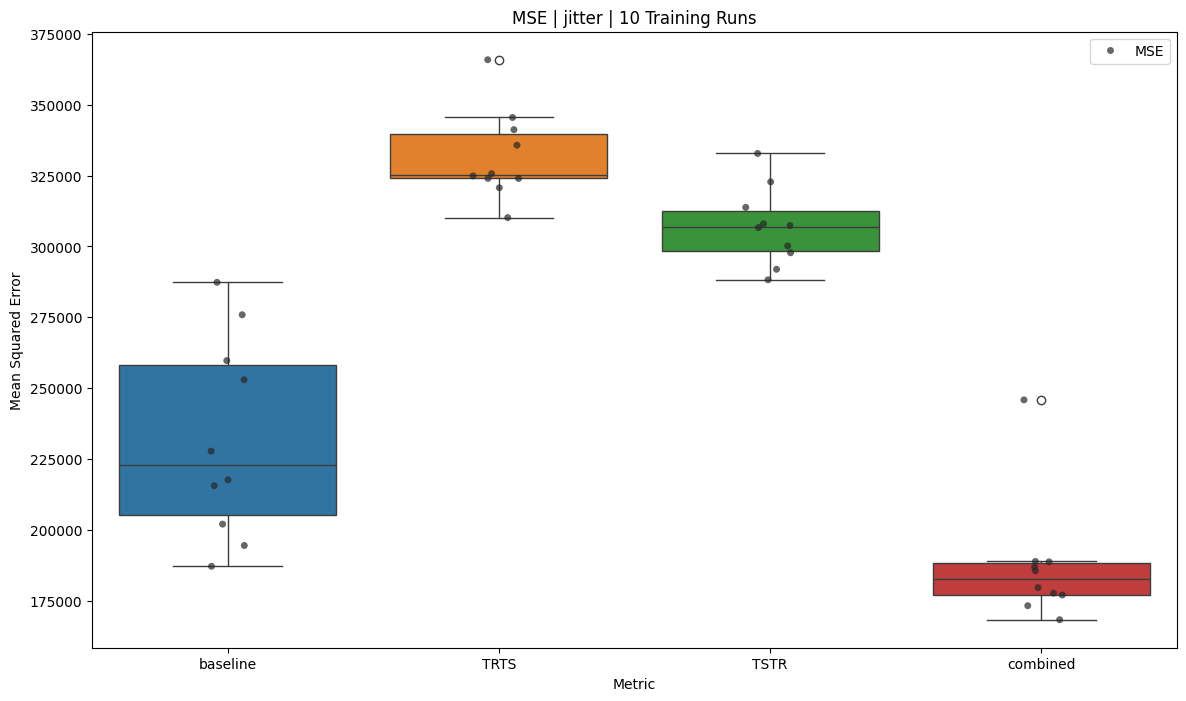

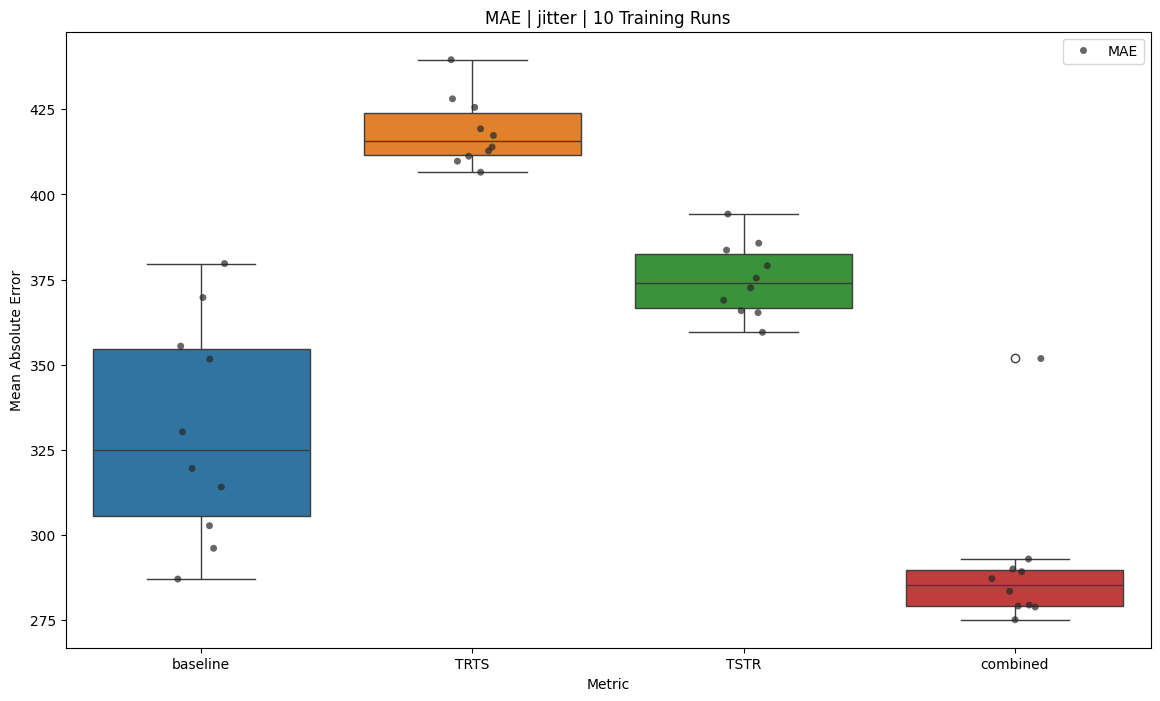

In [9]:
# plot results
plt.figure(figsize=(14, 8))
sns.boxplot(x='Model', y='Error', hue='Model', data=mse_results)
sns.stripplot(x='Model', y='Error', hue='Metric', data=mse_results, dodge=True, jitter=True, palette='dark:black', alpha=0.7)
plt.ylabel('Mean Squared Error')
plt.xlabel('Metric')
plt.title(f'MSE | {syn_data_type} | {hyperparameters["num_evaluation_runs"]} Training Runs')
plt.legend()

plt.figure(figsize=(14, 8))
sns.boxplot(x='Model', y='Error', hue='Model', data=mae_results)
sns.stripplot(x='Model', y='Error', hue='Metric', data=mae_results, dodge=True, jitter=True, palette='dark:black', alpha=0.7)
plt.ylabel('Mean Absolute Error')
plt.xlabel('Metric')
plt.title(f'MAE | {syn_data_type} | {hyperparameters["num_evaluation_runs"]} Training Runs')
plt.legend()

In [ ]:
0.2*1e06

200000.0